# Overview
Use this notebook to convert an OCT image you have to an H&E image in order to evaluate how the code works.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-UseModel/blob/main/ConvertOCTImagesToHistology.ipynb) and run.

## Notebook's Inputs:

In [1]:
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel
%run /content/OCT2Hist-UseModel/setup_env.ipynb

Cloning into 'OCT2Hist-UseModel'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 192 (delta 16), reused 25 (delta 6), pack-reused 156
Receiving objects: 100% (192/192), 8.62 MiB | 18.39 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 5.94 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'
Mounted at /content/drive/
/content/OCT2Hist-UseModel
Drive already mounted at /content/drive/; to at

In [2]:

oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Raw Data Used In Paper (Paper V2)/LG-19 - Slide04_Section02 (Fig 3.c)/OCTAligned.tiff"



#Virtual oct2hist inputs (constants):

In [3]:
#how many microns per pixel for each axis
microns_per_pixel_z = 1
microns_per_pixel_x = 1

# Path to a folder in drive to output the converted H&E images, leave blank if
# you don't want to save H&E image to drive.
histology_output_image_folder = ""

#pix2pix input sizes
VIRTUAL_HIST_WIDTH = 256
VIRTUAL_HIST_HEIGHT = 256
#verify input sizes
MICRONS_PER_PIXEL_Z_TARGET = 2
MICRONS_PER_PIXEL_X_TARGET = 4

# Set Up Environment
Clone repository, install dependencies:

# Preprocess
Mask images, crop and convert to the right size

Text(0.5, 1.0, 'Original OCT image ((1106, 1413, 3))')

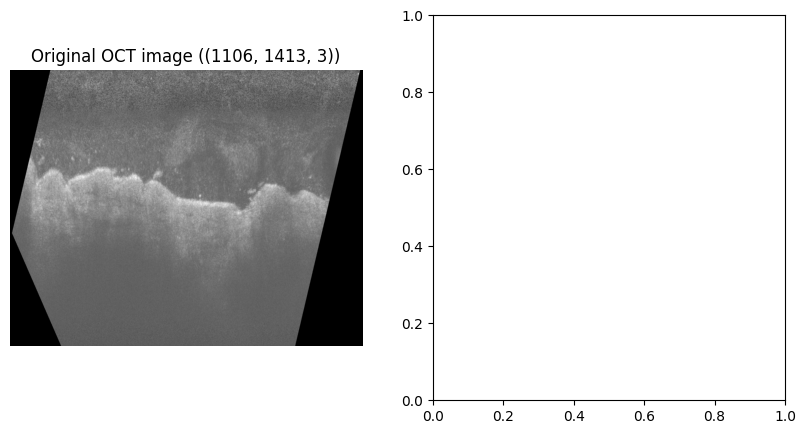

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load OCT image
oct_image_orig = cv2.imread(oct_input_image_path)
oct_image_orig = cv2.cvtColor(oct_image_orig, cv2.COLOR_BGR2RGB)

oct_image = oct_image_orig.copy()
# Show Images to user
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
oct_image_orig_shape = oct_image.shape
axes[0].imshow(oct_image)
axes[0].axis("off")
axes[0].set_title(f"Original OCT image ({oct_image_orig_shape})")



In [7]:
#calculate the new image size to according to source and target micron/pixel rate.
new_image_width = int(oct_image.shape[1] * microns_per_pixel_x / MICRONS_PER_PIXEL_X_TARGET)
new_image_height = int(oct_image.shape[0] * microns_per_pixel_z / MICRONS_PER_PIXEL_Z_TARGET)

In [10]:
from utils.masking import mask_image
preprocessed_img, filt_img = mask_image(oct_image)


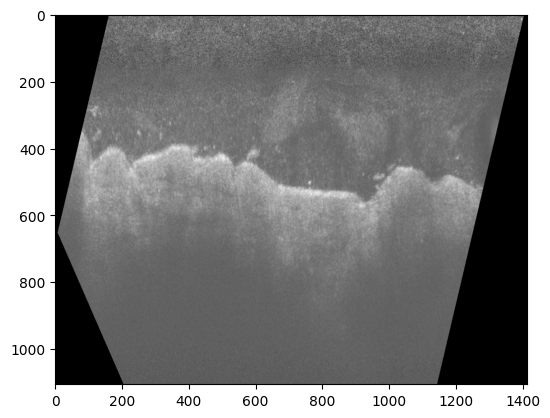

In [13]:
from utils.show_images import showImg
showImg(oct_image)

#visualize user input to processed input

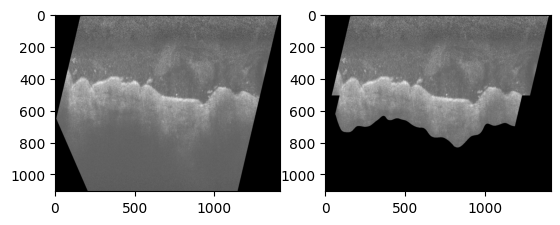

In [14]:
from utils.show_images import showTwoImgs
#visualize
showTwoImgs(oct_image_orig, preprocessed_img)

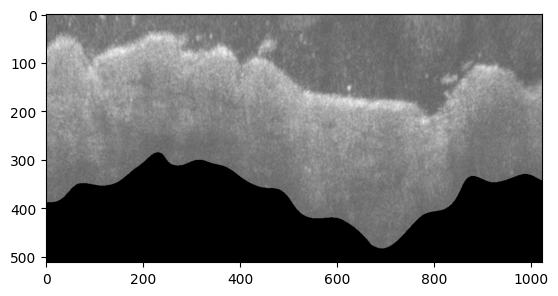

In [15]:
from utils.crop import crop
from utils.show_images import showImg
cropped = crop(preprocessed_img)
showImg(cropped)

In [16]:
resized = cv2.resize(cropped, [VIRTUAL_HIST_WIDTH,VIRTUAL_HIST_HEIGHT] , interpolation=cv2.INTER_AREA)
o2h_input = resized

#visualize oct2hist input

#visualize user input to o2h input

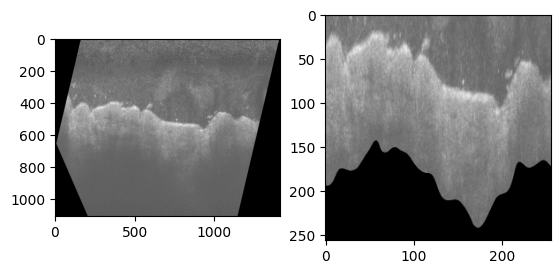

In [17]:
from utils.show_images import showTwoImgs
#visualize
showTwoImgs(oct_image, o2h_input)

In [18]:
# Perform pre-process
oct_image_preprocessed = o2h_input

# Show image to user
oct_image_preprocessed_shape = oct_image_preprocessed.shape
axes[1].imshow(oct_image)
axes[1].axis("off")
axes[1].set_title(f"Preprocessed OCT image ({oct_image_preprocessed_shape})")
plt.show()

Format image the way that pix2pix code likes it

# Run Model

In [19]:
def oct2hist_input():
        return oct_image_preprocessed

In [22]:
%run oct2hist.ipynb

# Show results

In [20]:
# Load the virtual histology image
histology_image = cv2.imread(oct2hist_output_path())
histology_image = cv2.cvtColor(histology_image, cv2.COLOR_BGR2RGB)
from utils.img_utils import showImg
showImg(histology_image)

NameError: ignored

In [ ]:
#visualize
height,width = cropped.shape[:2]
histology_image_resized = cv2.resize(histology_image, [width,height] , interpolation=cv2.INTER_AREA)
# present side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(cropped)
axes[0].axis("off")
axes[0].set_title("OCT")
axes[1].imshow(histology_image_resized)
axes[1].axis("off")
axes[1].set_title("Virtual Histology")
plt.show()